In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
os.chdir('C:\\Users\\Nevena\\Desktop\\LSDM project\\Data\\train')
lifetime=pd.read_csv('lifetime.csv',header=0,index_col=0)
lifetime_features=pd.read_csv('lifetime_features.csv',header=0,index_col=0)
size=pd.read_csv('size.csv',header=0,index_col=0)
spectrum=pd.read_csv('spectrum.csv',header=0,index_col=0)
labels=pd.read_csv('train_labels.csv',header=0,index_col=0)
scattering=pd.read_csv('scattering.csv',header=0,index_col=0)

# Transformisanje podataka  u pogodan oblik

In [3]:
lifetime_features_transformed=np.array(lifetime_features)

In [4]:
scattering_transformed = [np.array(scattering.iloc[i, :]).reshape(20, 120) for i in range(scattering.shape[0])]
spectrum_transformed = [np.array(spectrum.iloc[i, :]).reshape(4, 32) for i in range(spectrum.shape[0])]
lifetime_transformed = [np.array(lifetime.iloc[i, :]).reshape(4, 24) for i in range(lifetime.shape[0])]

In [5]:
indices1 = np.array(range(scattering.shape[0]))

random.seed(0)
random.shuffle(indices1)

new_scattering = [scattering_transformed[i] for i in indices1]

new_spectrum = [spectrum_transformed[i] for i in indices1]

new_lifetime = [lifetime_transformed[i] for i in indices1]

new_labels = [labels['Pollen'][i] for i in indices1]

new_lifetime_features= [lifetime_features_transformed[i] for i in indices1]

new_size = [size['size'][i]for i in indices1]



In [6]:
index = int(np.round(0.8 * len(scattering)))

train1 = new_scattering[:index]
val1 = new_scattering[index:]

train2 = new_spectrum[:index]
val2 = new_spectrum[index:]

train3 = new_lifetime[:index]
val3 = new_lifetime[index:]

train_size = new_size[:index]
val_size = new_size[index:]

train_lf_f = new_lifetime_features[:index]
val_lf_f = new_lifetime_features[index:]

train_labels = new_labels[:index]
val_labels = new_labels[index:]

In [7]:
def create_tensor(data):

    dimension = len(data[0].shape)
    if dimension == 1:
        tensor = torch.Tensor(data)
    elif dimension == 0:
        tensor = torch.Tensor(data).unsqueeze_(0).permute(1, 0)
    else:
        tensor = torch.Tensor(data).unsqueeze_(0).permute(1, 0, 2, 3)

    return tensor

In [8]:
train_tensor1 = create_tensor(train1)
train_tensor2 = create_tensor(train2)
train_tensor3 = create_tensor(train3)

val_tensor1 = create_tensor(val1)
val_tensor2 = create_tensor(val2)
val_tensor3 = create_tensor(val3)

C:\Users\Nevena\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  if __name__ == '__main__':


# Definisanje dataloadera

In [9]:
train_list1 = [[train_tensor1[i], train_labels[i]] for i in range(train_tensor1.shape[0])]
train_list2 = [[train_tensor2[i], train_labels[i]] for i in range(train_tensor2.shape[0])]
train_list3 = [[train_tensor3[i], train_labels[i]] for i in range(train_tensor3.shape[0])]

val_list1 = [[val_tensor1[i], val_labels[i]] for i in range(val_tensor1.shape[0])]
val_list2 = [[val_tensor2[i], val_labels[i]] for i in range(val_tensor2.shape[0])]
val_list3 = [[val_tensor3[i], val_labels[i]] for i in range(val_tensor3.shape[0])]

trainloader1 = DataLoader(
    dataset = train_list1, 
    batch_size = 600,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)
trainloader2 = DataLoader(
    dataset = train_list2, 
    batch_size = 600,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)
trainloader3 = DataLoader(
    dataset = train_list3, 
    batch_size = 600,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)
valloader1 = DataLoader(
    dataset = val_list1, 
    batch_size = 600,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)
valloader2 = DataLoader(
    dataset = val_list2, 
    batch_size = 600,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)
valloader3 = DataLoader(
    dataset = val_list3, 
    batch_size = 600,
    shuffle = False,
    num_workers = 0,
    pin_memory = False
)

# Definisanje modela

In [10]:
#valja, ali hoću bolje
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.scat_conv = nn.Sequential(
            nn.BatchNorm2d(1), nn.Conv2d(1, 10, 5), nn.MaxPool2d(2), nn.ReLU(),
            nn.BatchNorm2d(10), nn.Conv2d(10, 20, 3), nn.MaxPool2d(2), nn.Dropout2d(), nn.ReLU()
        )
        self.spec_conv = nn.Sequential(
            nn.BatchNorm2d(1), nn.Conv2d(1, 50, (1, 5)), nn.ReLU(),
            nn.BatchNorm2d(50), nn.Conv2d(50, 100, 3), nn.Dropout2d(), nn.ReLU()
        )
        self.liti1_conv = nn.Sequential(
            nn.BatchNorm2d(1), nn.Conv2d(1, 70, (1, 7)), nn.ReLU(),
            nn.BatchNorm2d(70), nn.Conv2d(70, 140, (1, 5)), nn.ReLU(),
            nn.BatchNorm2d(140), nn.Conv2d(140, 200, 3), nn.Dropout2d(), nn.ReLU()
        )
        self.scat_fc = nn.Sequential(nn.Linear(1680, 100), nn.ReLU(), nn.Dropout2d())
        self.spec_fc = nn.Sequential(nn.Linear(5200, 100), nn.ReLU(), nn.Dropout2d())
        self.liti1_fc = nn.Sequential(nn.Linear(4800, 100), nn.ReLU(), nn.Dropout2d())
        self.final_fc = nn.Sequential(nn.Linear(300, 12), nn.LogSoftmax(dim=1))

    def forward(self, data):
        x1 = self.scat_conv(data[0])
        x2 = self.spec_conv(data[1])
        x3 = self.liti1_conv(data[2])

        x1 = torch.flatten(x1, 1)
        x2 = torch.flatten(x2, 1)
        x3 = torch.flatten(x3, 1)

        x1 = self.scat_fc(x1)
        x2 = self.spec_fc(x2)
        x3 = self.liti1_fc(x3)

        x = torch.cat((x1, x2, x3), 1)

        return self.final_fc(x)
model_tri = Net()

# Definisanje parametara

In [11]:
#hyperparameter tuning

In [12]:
all_train_losses, all_val_losses, epoch_list = [], [], [-1]
plot_every = 2

def plot_losses(epoch_list, train_losses, val_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch_list, train_losses)
    plt.plot(epoch_list, val_losses)
    plt.xlabel("Epoch number")
    plt.ylabel("Cost")
    plt.legend(["Train", "Validation"], fontsize=20)
    matplotlib.rcParams.update({'font.size': 20})
    plt.show()

In [13]:
#menjam optimizer sa 0.001 na 0.01
optimizer = optim.SGD(model_tri.parameters(), lr=0.01, momentum=0.9)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.NLLLoss()

In [ ]:
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
#def train_cifar(config, checkpoint_dir=None, data_dir=None):

def train_cifar(config,checkpoint_dir=None):
    net = Net()

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)


    trainloader11 = torch.utils.data.DataLoader(
        train_list1,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    trainloader22 = torch.utils.data.DataLoader(
        train_list2,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    trainloader33 = torch.utils.data.DataLoader(
        train_list1,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader11 = torch.utils.data.DataLoader(
        val_list1,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    valloader22 = torch.utils.data.DataLoader(
        val_list2,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    valloader33 = torch.utils.data.DataLoader(
        val_list3,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for batch_idx, (data1, data2, data3) in enumerate(zip(trainloader11, trainloader22, trainloader33)):
            # get the inputs; data is a list of [inputs, labels]
            inputs = [data1[0],data2[0],data3[0]]
            labels = data[1]
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for batch_idx, (data1, data2, data3) in enumerate(zip(valloader1,valloader2,valloader3)):
            with torch.no_grad():
                inputs = [data1[0],data2[0],data3[0]]
                labels = data[1]
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    #data_dir = os.path.abspath("./data")
    #load_data(data_dir)
    config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([200, 400, 600, 100])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    #best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

In [ ]:
main(num_samples=5, max_num_epochs=5, gpus_per_trial=0)

# Treniranje modela

Epoch 51: Train[********] Validation[**]  Training Loss = 1.4879695, Validation Loss = 1.3404958
Epoch 52: Train[********] Validation[**]  Training Loss = 1.4433174, Validation Loss = 1.3234613


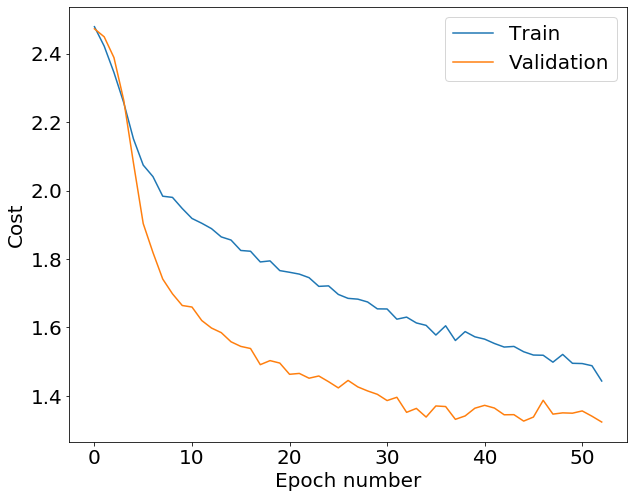

Epoch 53: Train[

C:\Users\Nevena\Anaconda3\lib\site-packages\torch\nn\functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


*******Training stopped by user.


In [31]:
try:
    while True:
        print("Epoch " + str(epoch_list[-1] + 1) + ": Train[", end="")
        train_losses, val_losses = [], []
        
        model_tri.train()
        for batch_idx, (data1, data2, data3) in enumerate(zip(trainloader1, trainloader2, trainloader3)):
            
            samples1 = [data1[0],data2[0],data3[0]]
            labels = data1[1]
            
            optimizer.zero_grad()
            model_out = model_tri(samples1)
            loss = loss_fn(model_out, labels)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.data.numpy())
            
            print("*", end="")
        print("] Validation[", end="")

        model_tri.eval()
        for batch_idx, (data1, data2, data3) in enumerate(zip(valloader1,valloader2,valloader3)):
            
            samples = [data1[0],data2[0],data3[0]]
            labels = data1[1]

            model_output = model_tri(samples)
            loss = loss_fn(model_output, labels)
            val_losses.append(loss.data.numpy())

            print("*", end="")
        print("] ", end="")

        epoch_list.append(epoch_list[-1] + 1)
        all_train_losses.append(np.mean(train_losses))
        all_val_losses.append(np.mean(val_losses))
        print(" Training Loss = %a, Validation Loss = %a" % (all_train_losses[-1], all_val_losses[-1]))

        if epoch_list[-1] % plot_every == 0 and len(epoch_list) > 2:
            plot_losses(epoch_list[1:], all_train_losses, all_val_losses)
        
except KeyboardInterrupt:
    print("Training stopped by user.") 

In [32]:
model_tri.eval()
#torch.save(model.state_dict(), path_to_save)

model_tri.cpu()
outputs = model_tri([val_tensor1,val_tensor2,val_tensor3])
_, predicted = torch.max(outputs.data, 1)

cm = confusion_matrix(val_labels, predicted.numpy())
f1 = f1_score(val_labels, predicted.numpy(), average="weighted")

print('F1 score: ', f1)
print('Confusion matrix: ')
print(cm)

F1 score:  0.5927927648867918
Confusion matrix: 
[[58  4  4 12  1  7  1  2  4  4  4  0]
 [ 3 59  2 10  2  3 18  1  0  4  6  0]
 [ 0  2 57  2  7 12  0  3  3  6  1  1]
 [ 2  7  1 64  3  4  4  0  2  9  9  0]
 [ 1  1  3  2 72  3  5  0  0  1  2  2]
 [ 3  2 19  6  4 39  3  3  2 18  3  1]
 [ 0  8  3  4  3  1 73  1  1  5  1  5]
 [ 0  5  6  0  1  0  0 62  1 16  3  1]
 [ 2  9  1  7  0  3  2  5 44 13 15  1]
 [ 0  5  2  3  5  2  1  4  1 52  9  0]
 [ 0 14  0 13  2  2  2  4 10  9 33  1]
 [ 1  0  2  0  2  3  1  8  0  9  0 95]]


# Ucitavanje test direktorijuma

In [18]:
os.chdir('C:\\Users\\Nevena\\Desktop\\LSDM project\\Data\\test')
scattering_test=pd.read_csv('scattering.csv',header=0,index_col=0,na_values='?')
scattering_test_transformed = [np.array(scattering_test.iloc[i, :]).reshape(20, 120) for i in range(scattering_test.shape[0])]
sc_test_transf_np= np.array(scattering_test_transformed)

In [19]:
test_tensor1 = create_tensor(sc_test_transf_np)

In [20]:
spectrum_test=pd.read_csv('spectrum.csv',header=0,index_col=0)
lifetime_test=pd.read_csv('lifetime.csv',header=0,index_col=0)

spectrum_test_transformed = [np.array(spectrum_test.iloc[i, :]).reshape(4, 32) for i in range(spectrum_test.shape[0])]
lifetime_test_transformed = [np.array(lifetime_test.iloc[i, :]).reshape(4, 24) for i in range(lifetime_test.shape[0])]

spectrum_test_transf_np= np.array(spectrum_test_transformed)
lifetime_test_transf_np = np.array(lifetime_test_transformed)

test_tensor2=create_tensor(spectrum_test_transf_np)
test_tensor3=create_tensor(lifetime_test_transf_np)

# Cuvanje modela

In [33]:
model_tri.cpu()
outputs = model_tri([test_tensor1,test_tensor2,test_tensor3])
values,predicted = torch.max(outputs.data, 1)

In [34]:
predicted

tensor([9, 9, 0,  ..., 9, 9, 4])

In [35]:
np_arr = outputs.cpu().detach().numpy()

In [36]:
import math
predicted_labels=[]
for i in np_arr:
    maximum=max(i)
    for j in range(len(i)):
        if(i[j]==maximum):
            predicted_labels.append(j)
pred_lab=np.array(predicted_labels)

In [37]:
pred_lab

array([9, 9, 0, ..., 9, 9, 4])

In [38]:
df = pd.DataFrame(pred_lab, columns=['Pollen'])
df.to_csv('predict_concat6002.csv')

In [39]:
datat=pd.read_csv('predict_concat6002.csv')
datat.rename(columns = {'Unnamed: 0':'ID'}, inplace = True)

In [40]:
datat.to_csv('predict_concat6002.csv', index=False)

In [41]:
dff=pd.read_csv('predict_concat6002.csv')

In [42]:
dff

,ID,Pollen
0,0,9
1,1,9
2,2,0
3,3,10
4,4,6
...,...,...
3861,3861,11
3862,3862,5
3863,3863,9
3864,3864,9


In [ ]:
dff1=pd.read_csv('predict_concat4.csv')

In [ ]:
raz=0
for i in range(len(pred_lab)):
    if(dff1["Pollen"][i]!=dff["Pollen"][i]):
        raz=raz+1
print(raz)
#predict_concat2 je u epohi 53 zaustavljena

In [ ]:
dff["Pollen"][0]